Conditioning was observed to not be working well. 

This code is to test it.


Train a model on its generated data, and test whether generations for a specific truthtable matches the expected output.

In [1]:
from bootstrapSetup import *
from IPython.display import display, clear_output

dataset generated as 'loader
embedder created as transformer
Embedded shape: torch.Size([4, 128])
Using device: cuda


In [2]:
# Hide

def checkConnectivity(connectionMap, socketMap):
    curIndex = 0
    connections = []
    exhaustedSockets = set()

    def exhaustSocketSource(socket):
        if any(not s.isSource for c in socketMap[socket] for s in connectionMap[c]): # if socket transmits to anything
            exhaustedSockets.add(socket)

        for c in socketMap[socket]:
            if c not in connections:
                connections.append(c)

    for inp, pos in inpSockets:
        exhaustSocketSource(inp)
    
    while curIndex < len(connections):
        c = connections[curIndex]
        for s in connectionMap[c]:
            if not s.isSource:
                exhaustedSockets.add(s)

            prefix, idnum, comptype = s.name

            if comptype:
                if (f"{prefix}{idnum}base" in exhaustedSockets and 
                    f"{prefix}{idnum}collector" in exhaustedSockets):
                    if f"{prefix}{idnum}emitter" not in connections and socketMap[f"{prefix}{idnum}emitter"]:
                        if any(not s.isSource for c in socketMap[f"{prefix}{idnum}emitter"] for s in connectionMap[c]):
                            exhaustSocketSource(f"{prefix}{idnum}emitter")

        curIndex += 1
    return connections, exhaustedSockets

def prePruningv2(socketMap, exhaustedSockets):
    connectedInps = []
    connectedOuts = []

    notConnectedGateIDs = []
    for s in socketMap:
        connected = s in exhaustedSockets
        prefix, idnum, comptype = s.name

        if comptype:
            if not connected and int(idnum) not in notConnectedGateIDs:
                notConnectedGateIDs.append(int(idnum))
        else:
            if connected:
                if prefix == "inp":
                    connectedInps.append(int(idnum))
                else: 
                    connectedOuts.append(int(idnum))


    return connectedInps, connectedOuts, notConnectedGateIDs

def gateRemoval(circuit, gatesToClean):
    if len(gatesToClean) == 0:
        return circuit
    
    gateToCleanIndex = 0
    curGate = 0
    for i in range(circuit.shape[0]):
        for j in range(circuit.shape[1]):
            if circuit[i][j] > 1:
                if gatesToClean[gateToCleanIndex] == curGate:
                    circuit[i][j] = 1
                    gateToCleanIndex += 1
                    if gateToCleanIndex >= len(gatesToClean):
                        return circuit

                curGate += 1
    
    return circuit


def afterPruningv2(circuit, wiresets, connectedSets):
    circuitWasUpdated = False
    for i in range(circuit.shape[0]):
        for j in range(circuit.shape[1]):
            if wiresets[i][j] not in connectedSets and circuit[i][j] == 1:
                circuit[i][j] = 0
                circuitWasUpdated = True

    return circuit, circuitWasUpdated


# Prunes excess wires from the circuit.
def CrossValue(circuit, i, j):
    up     = circuit[i - 1][j] if i > 0 else 0
    center = circuit[i][j]
    down   = circuit[i + 1][j] if i < circuit.shape[0] - 1 else 0
    left   = circuit[i][j - 1] if j > 0 else 0
    right  = circuit[i][j + 1] if j < circuit.shape[1] - 1 else 0

    return center + up + down + left + right


# Prunes excess wires from the circuit.
def pruneExcessWires(circuit):
    circuitDirty = False
    
    for j in range(1, circuit.shape[0] - 1):
        for i in range(circuit.shape[1]):
            crossValue = CrossValue(circuit, i, j)

            if crossValue < 3 and circuit[i][j] == 1:
                circuit[i][j] = 0
                circuitDirty = True


    #For end columns, allow wires connected to sockets
    for j in [0, circuit.shape[0] - 1]:
        for i in range(circuit.shape[0]):
            crossValue = CrossValue(circuit, i, j)

            if not i % 4 == 0 and crossValue < 3 and circuit[i][j] == 1:
                circuit[i][j] = 0
                circuitDirty = True
            elif i % 4 == 0 and crossValue < 2 and circuit[i][j] == 1:
                circuit[i][j] = 0
                circuitDirty = True              
    
    if circuitDirty:
        return pruneExcessWires(circuit)
    else: return circuit, circuitDirty

def requireGate(circuit):
    rows = circuit.shape[0]
    cols = circuit.shape[1]

    for i in range(rows):
        for j in range(cols):
            if circuit[i][j] > 1:
                return True
    return False

def generateSocketCombinations(inputSockets, relevantIndexes):
    #inputSockets = All available input sockets
    #relevantIndexes = the indexes of sockets that are connected to components
    
    usedSockets = [inputSockets[i][0] for i in relevantIndexes]
    
    # Generate all combinations (power set)
    orderList = []
    for r in range(len(usedSockets) + 1):
        for combo in combinations(usedSockets, r):
            orderList.append(list(combo))
    
    return orderList


In [ ]:
# Generate N Circuits
def GenerateN(model, amount = 100):
    model.eval()
    
    ## GENERATE CIRCUITS
    with torch.no_grad():
        batchX = torch.randint(size=(amount, 13, 13), high = 4, low = 0, device=device )
        batchX = imageToProbabilities(batchX, 4)

        batchY = torch.randint(size=(amount, 16, 8), high = 2, low = 0, device='cpu' )
        batchY = transformer(batchY).to(device)  
        
        # Inference with trainingsteps // 64 + 1, for faster generations. Even with this few steps, generations become perfect after training, due to small dataset.
        stepDivisor = 64
        inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, scheduler.TrainSteps // stepDivisor, device='cpu').long()
        
        for t in inferenceSteps:
            residual_cond = model(batchX.to(device).float(), t, batchY.float()) 
            residual = F.softmax(residual_cond, dim=1)
            batchX = scheduler.addNoise(residual.to('cpu'), t - 1).float()
        batchX = F.softmax(model(batchX.to(device), 0, batchY), dim=1)

        # Get circuit values
        argmaxedBatch = torch.argmax(batchX, dim=1, keepdim=True).cpu().numpy().squeeze()

        return argmaxedBatch
    

In [4]:
def getTables(circuits):
    #Prunes
    #Checks hashes
    #Simulates
    #Then, generates tables
    with torch.no_grad():
        tables = []
        simulatedCircuits = []
        simulatedCircuitHashes = []

        unique_hashes = {}
        circuitsErrors = defaultdict(int)
        for i in range((circuits.shape[0])):
            circuitDirty = True # Pruning flag

            circuit = circuits[i]
            while circuitDirty:
                socketMap, wireSets = GetSocketMap(circuit, inpSockets + outSockets)
                connectionMap = GetConnectionMap(socketMap)

                connectedSets, exhaustedSockets = checkConnectivity(connectionMap, socketMap)
                inps, outs, notConnectedGateIDs = prePruningv2(socketMap, exhaustedSockets)
                circuit = gateRemoval(circuit, notConnectedGateIDs)

                socketMap, wireSets = GetSocketMap(circuit, inpSockets + outSockets)
                connectionMap = GetConnectionMap(socketMap)
                connectedSets, exhaustedSockets = checkConnectivity(connectionMap, socketMap)
                circuit, changed1 = afterPruningv2(circuit, wireSets, connectedSets)
                circuit, changed2 = pruneExcessWires(circuit)                
                circuitDirty = changed1 or changed2

            hash = get_tensor_hash(circuit)
            if hash not in unique_hashes:
                if hash not in dataset.hashes:

                    #Get orderlist
                    if len(inps) > 1 and len(outs) > 0: # Bias to have only circuits with at least 2 inputs
                        orderlist = generateSocketCombinations(inpSockets, inps)

                        try:    
                            if requireGate(circuit):
                                truthTable = GetTruthTable(inps, outs, socketMap, connectionMap, orderlist)
                                tables.append(truthTable)
                                simulatedCircuits.append(circuit)
                                simulatedCircuitHashes.append(hash)
                                unique_hashes[hash] = i
                            else:
                                circuitsErrors["No gates"] += 1        

                        except Exception as e:
                            circuitsErrors[str(e)] += 1
                    else:
                        circuitsErrors["Not Sufficiently Connected"] += 1
                else:
                    circuitsErrors["Duplicate"] += 1
            else:
                circuitsErrors["New Duplicate"] += 1
                
        return tables, simulatedCircuits, simulatedCircuitHashes, circuitsErrors
    

In [5]:
# Trains for 1 epoch
def trainCatModel(catModel, dataloader, embeddingModel, losses, PLOTUPDATES = True):
    catModel.train()
    updateRate = 10 # For plotting purposes

    loss_fn = nn.CrossEntropyLoss() #nn.MSELoss(reduction='sum')

    if PLOTUPDATES:
        fig, ax = plt.subplots(figsize=(8, 5))
    opt = torch.optim.Adam(catModel.parameters(), lr=1e-4) 


    for batch, labels in dataloader:

        timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()

        noisyImgs = scheduler.addNoise(batch, timesteps)

        embeddings = embeddingModel(labels)

        pred = catModel(noisyImgs.to(device).float(), timesteps.to(device), embeddings.to(device))

        loss = loss_fn(pred, batch.to(device).argmax(axis=1)) 

        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

        if PLOTUPDATES:
            if len(losses) % updateRate == 0:
                clear_output(wait=True)  
                ax.clear()
                plt.plot(losses)
                plt.xlabel('Batch')
                display(fig)
                
    if PLOTUPDATES:
        clear_output(wait=True)  
        ax.clear()
    plt.plot(losses)
    plt.xlabel('Batch')
    if PLOTUPDATES:
        display(fig)

    return catModel, losses


In [8]:

class CategoricalDiffusionModelDeep(nn.Module):
    def __init__(self, imageSize, numCategories, embeddingSize, attentionHeads=8, guidanceProb=0.1):
        super().__init__()
        self.guidance_prob=guidanceProb
        self.model = UNet2DConditionModel(
            sample_size=imageSize, 
            in_channels=numCategories,  # Image channels
            out_channels=numCategories,
            cross_attention_dim=embeddingSize,  # Matches mbedding's token dim 
            attention_head_dim=attentionHeads,     # Smaller head dim for efficiency
            layers_per_block=5,       # how many ResNet layers to use per UNet block
            block_out_channels=(128, 128, 128), 
            down_block_types=(
                "CrossAttnDownBlock2D",  
                "CrossAttnDownBlock2D",
                "DownBlock2D",
            ),
            up_block_types=(
                "UpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
            ),
        )
        
    def forward(self, x, t, embedding):
        bs, ch, w, h = x.shape

        #Use guidance probability, to help the model learn that 'circuit behvaior' 
        # is a general feature and not specific to a particular embedding.
        if self.training:
            mask = torch.rand_like(embedding, device=x.device) < self.guidance_prob
            embedding[mask] = 0

        return self.model(x, t, encoder_hidden_states=embedding).sample

In [24]:
#model = CategoricalDiffusionModelDeep(13, 4, 128).to(device)
model = CategoricalDiffusionModel(13, 4, 128).to(device)
#model.load_state_dict(torch.load(os.path.join("output\\2025-05-07", "SquareFull3_model.pt")))
model.load_state_dict(torch.load(os.path.join("output\\2025-05-07", "SquareLess3_model.pt")))

<All keys matched successfully>

In [25]:
# Load the saved training data
with open(os.path.join("output\\2025-05-07", "SquareLess3_training_data.pkl"), 'rb') as f:
    data = pickle.load(f)
#data['circuitErrors'], data['trainingDict'], data['trainingDictSize'], data['dataIncrease'], data['amountShorter'], data['amountCircuitsGenerated']

In [11]:
trainingDict =data['trainingDict']
dataset = CircuitDataset(trainingDict)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

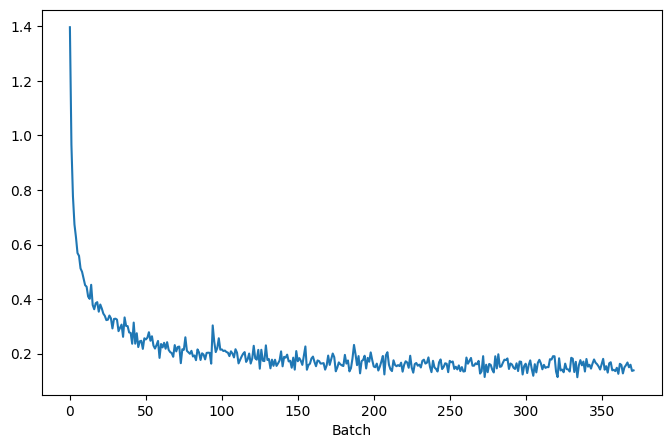

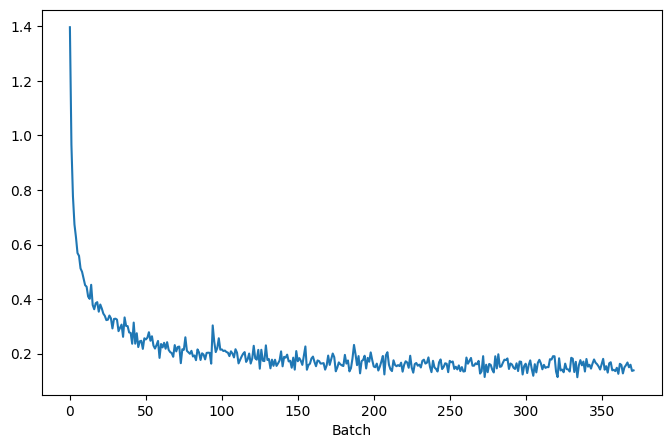

In [17]:
#loss = []
model, loss = trainCatModel(model, loader, transformer, loss)

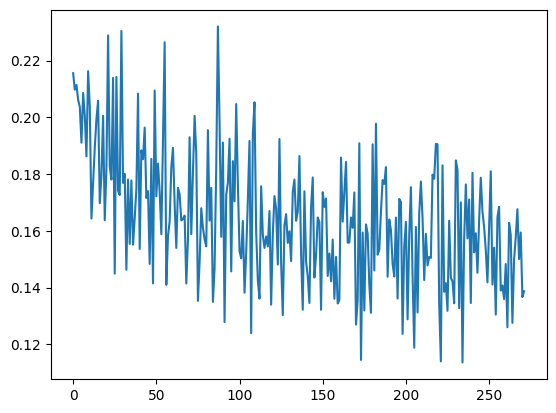

In [18]:
plt.plot(loss[100:])

In [19]:
def print25(item):
    cmap = ListedColormap(['white', 'black', 'red', 'blue'])
    cols = 5
    rows = min(len(item) + 4, 25) // cols
    if rows == 0:
        return

    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))

    for idx, ax in enumerate(axes.flat):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx >= len(item):
            continue
        ax.imshow(item[idx], cmap=cmap, vmin=0, vmax=3)
    plt.tight_layout()
    plt.show()

In [75]:
# Generate N Circuits
def Generate25(model, condition):
    model.eval()
    
    ## GENERATE CIRCUITS
    with torch.no_grad():
        batchX = torch.randint(size=(25, 13, 13), high = 4, low = 0, device=device )
        batchX = imageToProbabilities(batchX, 4)

        batchY = condition
        
        inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, scheduler.TrainSteps, device='cpu').long()
        
        for t in inferenceSteps:
            residual_cond = model(batchX.to(device).float(), t, batchY.float()) 
            residual = F.softmax(residual_cond, dim=1)
            batchX = scheduler.addNoise(residual.to('cpu'), t - 1).float()
        batchX = F.softmax(model(batchX.to(device), 0, batchY), dim=1)

        # Get circuit values
        argmaxedBatch = torch.argmax(batchX, dim=1, keepdim=True).cpu().numpy().squeeze()

        return argmaxedBatch

In [76]:
testCondition = torch.tensor([
        [0, 0, 2, 2, 0, 2, 2, 2 ],
        [1, 0, 2, 2, 0, 2, 2, 2 ],
        [0, 1, 2, 2, 0, 2, 2, 2 ],
        [1, 1, 2, 2, 1, 2, 2, 2 ],
    ])

testCondition = tablePadding(testCondition)
testCondition = testCondition.expand(25, 16, 8)
testCondition = transformer(testCondition).to(device)  


testOutput = Generate25(model, testCondition)

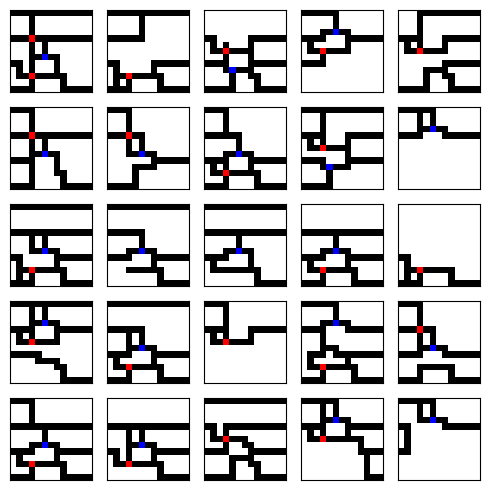

In [77]:
print25(testOutput)

______
What is the model predicting?

In [200]:
# Generate 1 circuit, and display the prediction after each step of inference

intermediateStates = []


testCondition = torch.tensor([
        [0, 0, 2, 2, 0, 2, 2, 2 ],
        [1, 0, 2, 2, 0, 2, 2, 2 ],
        [0, 1, 2, 2, 0, 2, 2, 2 ],
        [1, 1, 2, 2, 1, 2, 2, 2 ],
    ])

testCondition = tablePadding(testCondition)
testCondition = testCondition.expand(1, 16, 8)
testCondition = transformer(testCondition).to(device)  

## GENERATE CIRCUITS
with torch.no_grad():
    batchX = torch.randint(size=(1, 13, 13), high = 4, low = 0, device=device )
    batchX = imageToProbabilities(batchX, 4)

    batchY = testCondition
    
    inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, 8, device='cpu').long()
    
    intermediateStates.append(torch.argmax(batchX, dim=1, keepdim=True).cpu().numpy().squeeze())

    for t in inferenceSteps:
        residual_cond = model(batchX.to(device).float(), t, batchY.float()) 
        residual = F.softmax(residual_cond, dim=1)
        intermediateStates.append(torch.argmax(residual, dim=1, keepdim=True).cpu().numpy().squeeze())
        batchX = scheduler.addNoise(residual.to('cpu'), t - 1).float()
    batchX = F.softmax(model(batchX.to(device), 0, batchY), dim=1)
    intermediateStates.append(torch.argmax(batchX, dim=1, keepdim=True).cpu().numpy().squeeze())

    # Get circuit values
    argmaxedBatch = torch.argmax(batchX, dim=1, keepdim=True).cpu().numpy().squeeze()


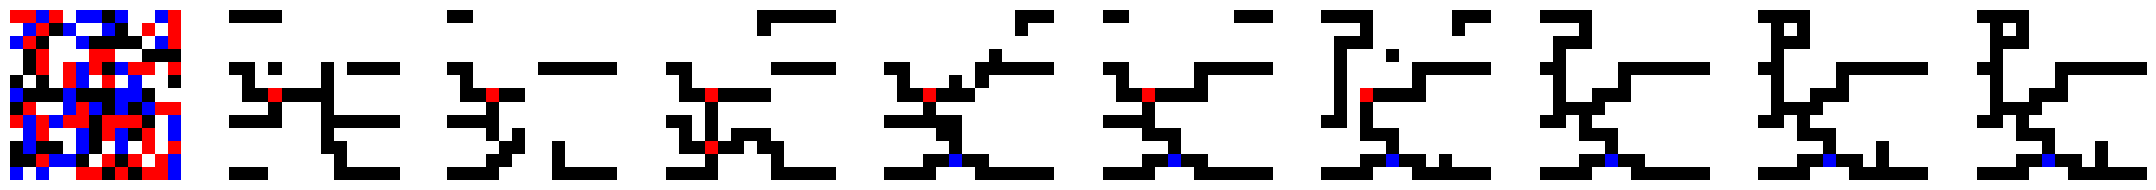

In [201]:
import matplotlib.pyplot as plt

# Assuming intermediateStates is a list or array-like with 11 items
# Each item could be a tensor or numpy array, and item[idx] is the actual image you want
fig, axes = plt.subplots(1, 10, figsize=(22, 2))  # One row, 11 columns
cmap = ListedColormap(['white', 'black', 'red', 'blue'])
for i, ax in enumerate(axes):
    ax.imshow(intermediateStates[i], cmap=cmap, vmin=0, vmax=3)
    ax.axis('off')  # Hide axes for better visual

plt.tight_layout()
plt.show()
